# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [1]:
import tensorflow as tf
from random import seed as random_seed
random_seed(50)
from numpy.random import seed as np_random_seed
np_random_seed(50)

tf.random.set_seed(50)

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7031291438779098005,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11761897984
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5343095368804875536
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1"]

In [4]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
# from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

env: PYTHONHASHSEED=0


In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input

In [6]:
from sklearn.utils.class_weight import compute_class_weight

## Paths
---

In [7]:
so_type = 'so_rl'
input_path_root = r'../../data/reprocess_data/fullRange_D'

loss_param=0.5
MODEL_TYPE="efficientB5"
version="v2"

# <model 저장>
# output_path_root = r'../results/'
output_path_root = f'../results/multiout/{MODEL_TYPE}/{loss_param}_full_range_1951_multiO3/{version}'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

try:
    os.makedirs(output_path_weight) 
    
except FileExistsError as err:      
    print(err)
# else:
#     print(output_path)

#     print(output_path_weight)

[Errno 17] File exists: '../results/multiout/efficientB5/0.5_full_range_1951_multiO3/v2/so_rl/weights/'


In [8]:
input_path_root

'../../data/reprocess_data/fullRange_D'

In [9]:
output_path_root

'../results/multiout/efficientB5/0.5_full_range_1951_multiO3/v2'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [10]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y, y_distance):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]]) # Right side,Left side !!!
        
        y_r_test= to_categorical(y[:,0], num_classes=3)
        y_l_test= to_categorical(y[:,1], num_classes=3)
        
        y = np.concatenate([y[:, 0], y[:, 1]])
        y_onehot=np.concatenate((y_r_test,y_l_test),axis=0)
        
        y_distance = np.concatenate([y_distance[:, 0], y_distance[:, 1]])
    
    return x, y, y_onehot, y_distance

In [11]:
x = np.load(os.path.join(input_path_root, f'fullRange_D.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'fullRange_D.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()

y_distance = y_distance.astype(np.float32)

print(x.max())
x=preprocess_input(x)
print(x.max())


255
255


In [12]:
#---------onehot function test------------------
x_tt, y_tt, y_onehot_tt,y_distance_tt=generate_data_by_patient(x,y,y_distance)

y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]

y_onehot_tt_r=list(y_onehot_tt_r)
y_onehot_tt_l=list(y_onehot_tt_l)

label_df["one-hot-r"]=y_onehot_tt_r
label_df["one-hot-l"]=y_onehot_tt_l

print("regression:",y_tt.min(),"||",y_tt.max())
print("classification:",y_onehot_tt.min(),"||",y_onehot_tt.max())
print("distance:",y_distance_tt.min(),"||",y_distance_tt.max())

label_df

#---------------------------------------------

regression: -1 || 1
classification: 0.0 || 1.0
distance: -24.48 || 25.12


,Unnamed: 0,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
1946,2069,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1947,2070,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
1948,2071,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
1949,2072,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


uint8 (1951, 879, 960, 6)
int64 (1951, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1951 non-null   int64  
 1   patient_id     1951 non-null   object 
 2   tx_phase       1951 non-null   object 
 3   angle_class_r  1951 non-null   int64  
 4   angle_class_l  1951 non-null   int64  
 5   distance(r)    1951 non-null   float64
 6   distance(l)    1951 non-null   float64
 7   one-hot-r      1951 non-null   object 
 8   one-hot-l      1951 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 137.3+ KB


None

/opt/conda/envs/tensor2.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


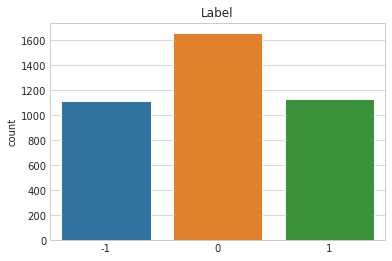

In [13]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
# display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [14]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])


print("calss -1:",len(cnt[cnt==-1]))
print("calss 0:",len(cnt[cnt==0]))
print("calss 1:",len(cnt[cnt==1]))

calss -1: 1113
calss 0: 1658
calss 1: 1131


## Model
---

In [15]:
def build_model():
    base_model = EfficientNetB5(include_top=False, weights=None, input_shape=None)    

    base_model.trainable=True
    
    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense_2')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)


    regression_prediction=layers.Dense(1, name='regression_prediction')(x)
    one_hot_prediction=layers.Dense(3, activation='softmax', name='classification')(regression_prediction)
    distance_prediction=layers.Dense(1, name='distance_prediction')(x)

    
    model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
#     model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
    
    return model

In [16]:
model=build_model()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

## Train the Model
---

In [18]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [19]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fine_tun = False

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])): #left???

    if kfold_idx ==4:
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        # 1. Data
        # ----------------------------------------

    #------DEBUG--------:
    #     print(test_idxs)     
    #     print(np.unique(y[test_idxs, 0], return_counts=True))
    #-------------------   

        x_train = x[train_idxs]
        y_train = y[train_idxs]
        y_distance_train =y_distance[train_idxs]
    #     label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, y_distance_train, y_distance_val = train_test_split(x_train, y_train, y_distance_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0])

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_distance_test =y_distance[test_idxs]
    #     label_df_test = label_df.iloc[test_idxs]

        #distance 누락!
        x_train, y_train,y_train_onehot, y_train_distance = generate_data_by_patient(x_train, y_train, y_distance_train)
        x_val, y_val, y_val_onehot, y_val_distance = generate_data_by_patient(x_val, y_val, y_distance_val)
        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test, y_distance_test)

        weight_for_m1 = (1 / len(y_train[y_train==-1]))*(len(y_train))/3.0 
        weight_for_0 = (1 / len(y_train[y_train==0]))*(len(y_train))/3.0 
        weight_for_1 = (1 / len(y_train[y_train==1]))*(len(y_train))/3.0

        class_weight2=[weight_for_0,weight_for_1,weight_for_m1]
        

        # 2. Paths
        # ----------------------------------------

        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)
            
      
        
        model = build_model()
        model.save(os.path.join(output_path, r'model.hdf5'))

        
        model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
              loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':loss_param},
              metrics={'regression_prediction':"mae",'classification':"acc",'distance_prediction':"mae"})

        print(len(model.trainable_weights))

        # 4. Train the Model.
        # ----------------------------------------

        # Callbacks
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)
        learning_sch = callbacks.LearningRateScheduler(scheduler)

        # Training batch size 16 -> 8
        model.fit(x_train,{'regression_prediction':y_train, 'classification':y_train_onehot,'distance_prediction':y_train_distance},
                  batch_size=1,
                  epochs=50,
                  validation_data=(x_val, {'regression_prediction':y_val,'classification':y_val_onehot,'distance_prediction':y_val_distance}),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=0,
                  verbose=1)

        K.clear_session()
        del model
    


K-Fold CV: 05/10
512
Epoch 1/50


KeyboardInterrupt: 

## Evaluation
---

In [24]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
5,QH0044,Post-Tx,1,1,9.15,7.06,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
7,QH0059,Post-Tx,1,-1,1.53,0.49,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
8,QH0067,Pre-Tx,1,1,3.98,2.06,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
9,QH0067,Post-Tx,1,1,2.91,2.08,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"


In [25]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
5,QH0044,Post-Tx,1,1,9.15,7.06,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
7,QH0059,Post-Tx,1,-1,1.53,0.49,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"


In [44]:
output_path

'../results/multiout/efficientB0/0.5_full_range_1951_multiO3/finetuning/v1/so_rl'

0
K-Fold CV: 01/10
[  13   15   25   36   62   67   68   81   87  101  124  130  154  156
  158  160  161  164  171  177  193  195  206  215  216  219  231  234
  252  263  264  287  309  310  311  320  329  359  363  366  375  376
  393  403  417  427  434  440  455  462  484  493  496  500  502  509
  514  517  537  542  545  563  569  576  579  584  586  599  612  614
  622  623  664  675  687  706  708  709  713  725  733  737  749  750
  770  784  787  794  819  822  824  832  836  842  855  864  866  880
  913  934  946  954  979  982  995 1008 1014 1040 1043 1044 1046 1057
 1060 1065 1086 1088 1090 1098 1104 1113 1117 1119 1124 1186 1209 1225
 1233 1236 1241 1251 1253 1254 1263 1320 1322 1338 1342 1347 1365 1374
 1380 1385 1404 1419 1478 1489 1506 1532 1543 1568 1571 1580 1591 1604
 1616 1650 1654 1656 1660 1665 1667 1670 1672 1705 1718 1719 1742 1743
 1744 1745 1750 1762 1773 1779 1785 1787 1789 1812 1815 1818 1822 1825
 1831 1835 1844 1847 1853 1857 1864 1877 1890 1898 1901 19

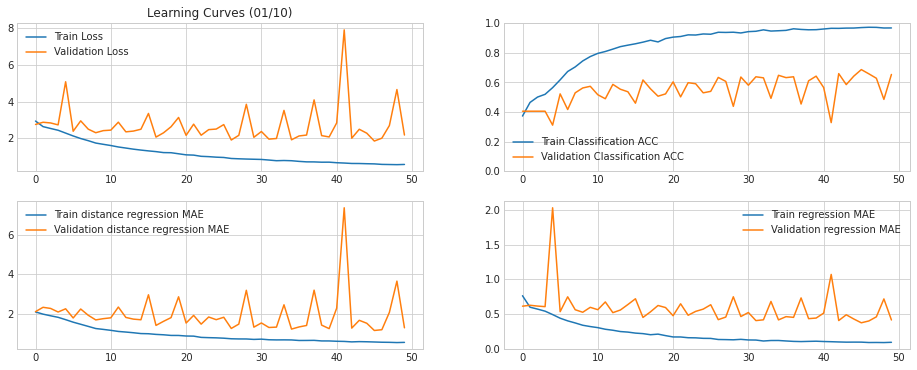

Min. validation loss epoch: 46
Max. Classification ACC epoch: 46
Max. Classification ACC: 0.68660968542099
Min. distance regression validation MAE epoch: 46
Min. regression validation MAE epoch: 46
2
K-Fold CV: 03/10
[   1   10   21   23   44   54   73   76   79   98   99  115  116  140
  151  162  190  192  204  212  220  243  247  255  261  265  275  306
  307  315  319  331  347  353  354  356  362  367  377  382  387  415
  416  429  464  467  480  487  516  522  535  543  549  552  556  580
  595  631  634  637  639  644  654  659  662  682  726  731  739  756
  761  766  778  786  790  792  798  811  815  817  830  831  844  845
  851  862  863  876  881  885  899  928  929  936  947  949  951  955
  963  980  999 1002 1012 1037 1050 1061 1066 1072 1092 1103 1114 1126
 1129 1145 1165 1175 1180 1196 1199 1201 1204 1212 1229 1242 1252 1262
 1265 1276 1278 1291 1302 1308 1310 1312 1325 1331 1336 1339 1346 1379
 1387 1395 1401 1402 1408 1423 1424 1427 1452 1459 1465 1492 1529 1531
 1

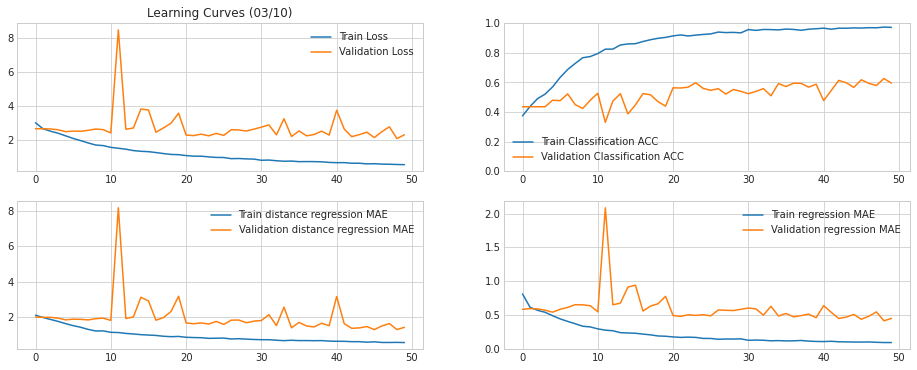

Min. validation loss epoch: 49
Max. Classification ACC epoch: 49
Max. Classification ACC: 0.6264204382896423
Min. distance regression validation MAE epoch: 46
Min. regression validation MAE epoch: 49
3
K-Fold CV: 04/10
[   4   19   27   39   46   47   56   63   64   72   75   82   85   88
  105  117  123  125  126  139  191  194  203  210  211  233  238  249
  251  257  259  270  277  296  299  312  333  339  340  349  365  371
  392  397  435  446  452  456  463  473  491  498  506  507  521  533
  538  544  547  558  582  604  621  626  628  642  657  660  665  673
  683  701  710  722  740  742  752  754  757  759  776  782  829  838
  840  841  847  861  869  883  890  898  900  907  908  911  915  920
  923  925  935  940  952  958  962  966  967  968  971 1003 1005 1010
 1017 1021 1034 1053 1070 1073 1080 1081 1094 1101 1106 1108 1115 1116
 1128 1130 1136 1139 1161 1166 1183 1190 1191 1203 1216 1231 1248 1277
 1287 1329 1340 1348 1351 1358 1359 1386 1397 1398 1435 1443 1464 1477


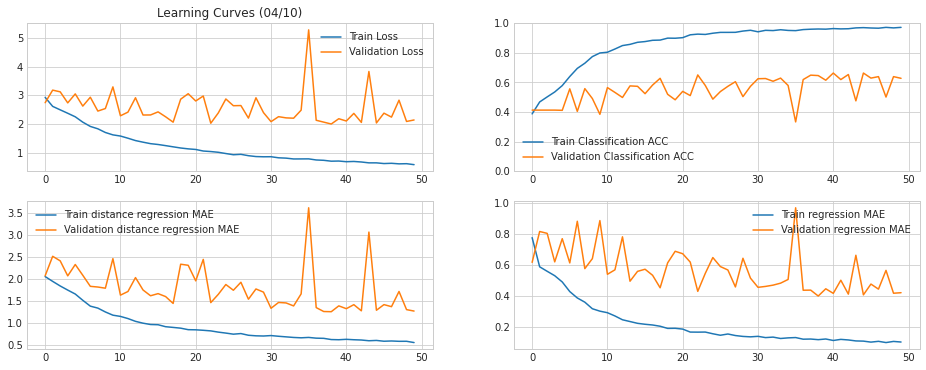

Min. validation loss epoch: 39
Max. Classification ACC epoch: 41
Max. Classification ACC: 0.6633522510528564
Min. distance regression validation MAE epoch: 39
Min. regression validation MAE epoch: 39
4
K-Fold CV: 05/10
[  28   37   51   66   70   77   84  109  110  114  119  128  132  145
  155  157  169  178  189  197  199  201  208  225  269  286  297  298
  302  324  326  336  350  378  383  394  405  409  411  413  414  425
  442  448  466  468  471  477  478  482  503  505  512  524  531  541
  553  554  555  589  593  598  601  608  632  636  641  649  669  676
  692  751  758  762  765  774  788  797  799  801  810  812  818  827
  868  877  894  896  904  905  914  931  932  941  944  950  956  957
  977  991 1013 1015 1023 1041 1051 1054 1074 1075 1079 1091 1096 1099
 1102 1111 1118 1125 1132 1149 1154 1160 1172 1179 1206 1232 1261 1267
 1315 1316 1324 1335 1345 1357 1360 1375 1382 1383 1399 1409 1412 1415
 1416 1434 1436 1439 1441 1450 1455 1460 1468 1476 1480 1487 1488 1491


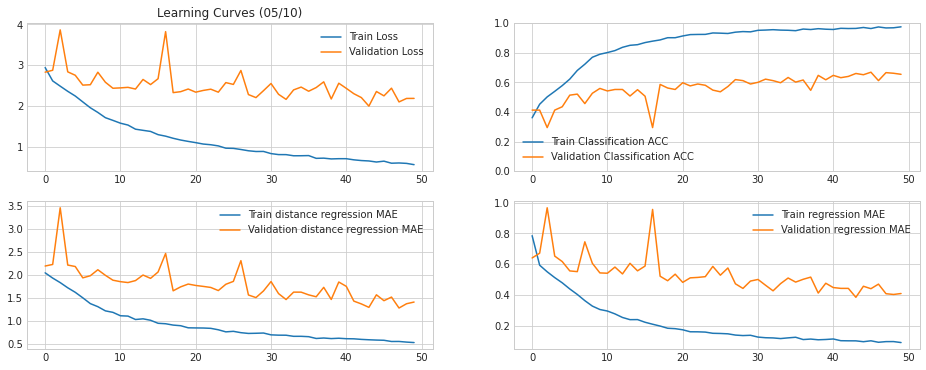

Min. validation loss epoch: 44
Max. Classification ACC epoch: 46
Max. Classification ACC: 0.6690340638160706
Min. distance regression validation MAE epoch: 48
Min. regression validation MAE epoch: 44
5
K-Fold CV: 06/10
[   0   30   31   59   74   93   95   97  120  131  137  147  183  230
  232  248  258  262  267  273  276  278  304  305  332  344  355  361
  369  370  373  379  380  389  398  421  428  431  437  447  460  469
  475  489  490  501  526  528  529  559  564  571  577  581  587  588
  597  600  605  610  615  616  624  629  633  645  647  652  670  671
  677  678  685  697  715  721  724  741  748  763  775  783  808  814
  825  834  837  856  870  874  878  879  887  888  901  906  926  937
  942  953  973  993 1006 1025 1027 1038 1047 1049 1067 1076 1087 1133
 1140 1141 1148 1158 1164 1169 1177 1202 1211 1246 1259 1268 1284 1297
 1305 1333 1344 1369 1384 1403 1405 1406 1410 1418 1444 1446 1447 1461
 1469 1472 1498 1502 1504 1508 1515 1520 1522 1525 1526 1553 1557 1567


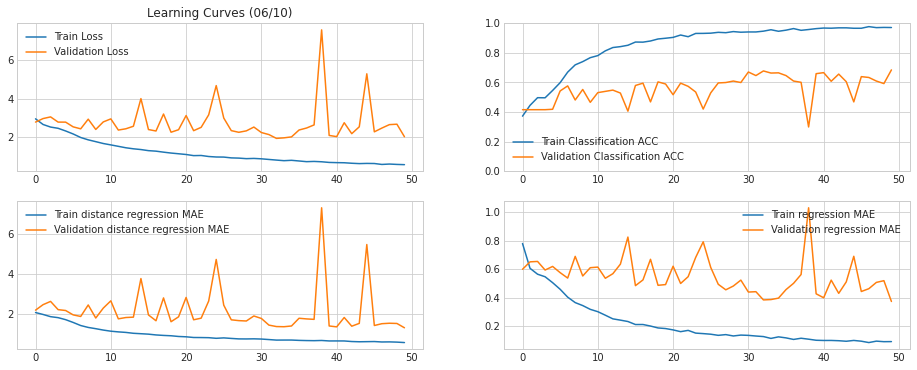

Min. validation loss epoch: 33
Max. Classification ACC epoch: 50
Max. Classification ACC: 0.6846590638160706
Min. distance regression validation MAE epoch: 50
Min. regression validation MAE epoch: 50
6
K-Fold CV: 07/10
[   2   16   26   35   53   61   83   86   94  108  129  133  134  149
  152  166  172  174  175  200  209  227  235  236  245  250  281  282
  284  288  293  303  322  323  334  335  352  385  391  432  439  450
  458  470  497  540  546  565  566  572  575  585  592  607  609  627
  630  640  643  653  655  661  668  696  698  699  702  717  732  736
  738  745  746  760  767  771  772  780  789  793  816  823  828  839
  843  849  854  865  875  884  903  922  933  938  948  961  965  976
  992  994 1001 1022 1028 1035 1042 1095 1100 1107 1110 1112 1123 1135
 1150 1151 1153 1174 1182 1193 1198 1205 1207 1213 1218 1219 1220 1235
 1238 1240 1243 1244 1247 1264 1281 1289 1292 1300 1307 1311 1318 1343
 1350 1363 1368 1417 1421 1430 1442 1449 1457 1473 1475 1496 1497 1499


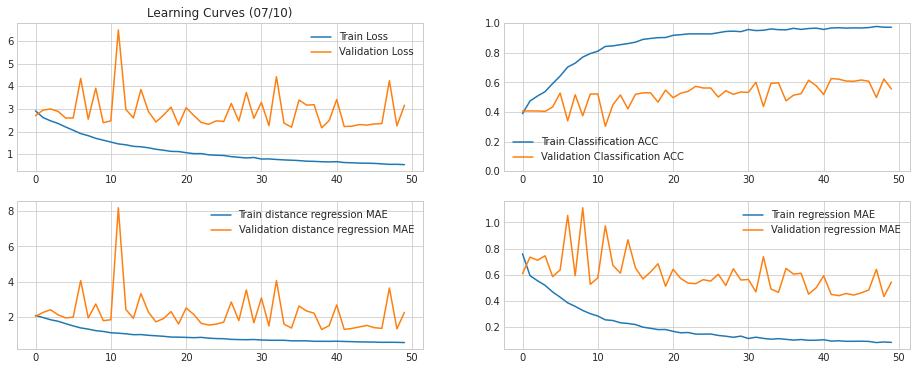

Min. validation loss epoch: 39
Max. Classification ACC epoch: 42
Max. Classification ACC: 0.6264204382896423
Min. distance regression validation MAE epoch: 39
Min. regression validation MAE epoch: 49
7
K-Fold CV: 08/10
[   6   34   38   40   45   57   58   60   71   78   80  103  104  111
  121  144  198  217  224  239  241  244  256  260  266  271  279  283
  291  313  328  345  346  360  401  406  407  410  419  420  423  424
  433  436  438  445  451  454  465  476  494  504  519  520  523  536
  539  557  567  590  594  596  602  611  619  620  667  690  693  705
  718  719  728  730  743  769  773  795  803  820  846  848  850  871
  891  902  921  930  939  943  959  964  970  986  987  997  998 1009
 1016 1020 1031 1039 1045 1062 1063 1064 1071 1077 1085 1120 1121 1127
 1146 1147 1159 1163 1167 1170 1176 1178 1181 1208 1221 1228 1245 1250
 1258 1270 1275 1299 1301 1303 1334 1349 1354 1355 1356 1364 1372 1378
 1390 1396 1420 1422 1429 1432 1433 1438 1448 1454 1463 1466 1479 1481


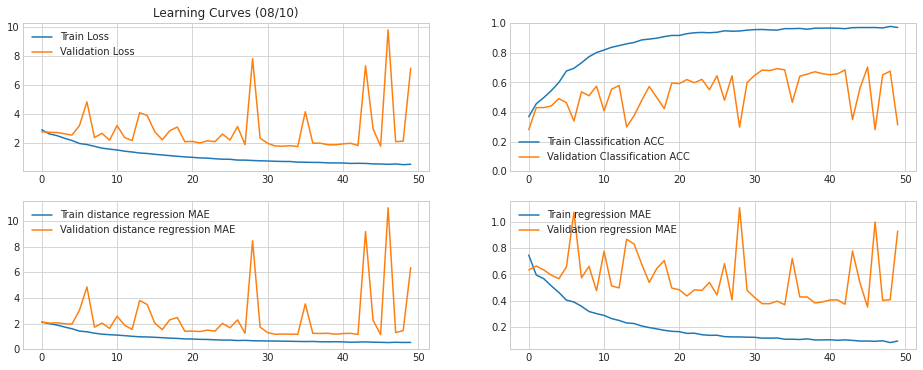

Min. validation loss epoch: 35
Max. Classification ACC epoch: 46
Max. Classification ACC: 0.703125
Min. distance regression validation MAE epoch: 46
Min. regression validation MAE epoch: 46
8
K-Fold CV: 09/10
[   5    7   11   14   18   32   52   69   92  100  107  113  118  127
  135  163  167  179  180  181  184  188  207  221  226  228  242  272
  285  290  294  301  308  314  316  327  330  338  343  357  372  374
  386  402  412  418  430  453  459  479  488  495  510  525  530  548
  591  613  625  663  684  707  711  716  720  723  727  734  753  777
  785  796  802  805  806  809  813  826  833  853  857  860  872  889
  893  909  910  918  960  972  975  985  988  996 1007 1032 1083 1084
 1134 1142 1143 1168 1171 1185 1188 1210 1217 1222 1257 1271 1273 1274
 1279 1280 1283 1285 1290 1293 1328 1330 1332 1337 1341 1352 1381 1389
 1392 1407 1413 1425 1437 1445 1453 1456 1471 1483 1495 1501 1507 1509
 1511 1512 1516 1538 1544 1554 1566 1577 1583 1599 1600 1607 1610 1614
 1619 1627

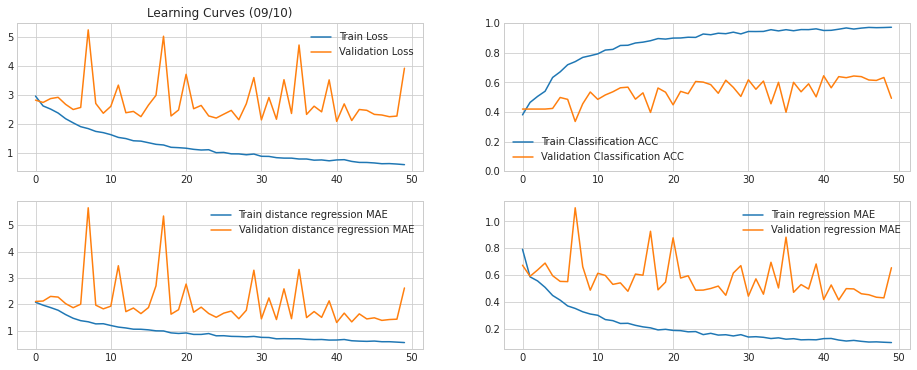

Min. validation loss epoch: 41
Max. Classification ACC epoch: 41
Max. Classification ACC: 0.6448863744735718
Min. distance regression validation MAE epoch: 41
Min. regression validation MAE epoch: 43
9
K-Fold CV: 10/10
[   3   12   20   22   24   29   33   41   42   48   55   91  102  122
  136  141  142  148  150  153  159  165  170  173  185  186  202  213
  240  246  254  268  274  292  295  300  318  321  325  337  341  351
  358  381  384  388  390  396  399  400  426  449  461  486  513  550
  562  568  583  603  606  618  646  650  651  656  666  679  681  694
  695  700  744  764  768  781  791  807  867  886  892  895  916  924
  945  969  974  981  983  984  990 1000 1011 1026 1029 1036 1048 1056
 1058 1069 1082 1089 1093 1097 1105 1109 1131 1137 1144 1157 1184 1187
 1192 1194 1195 1214 1223 1224 1226 1230 1234 1237 1249 1255 1256 1260
 1266 1269 1272 1282 1286 1288 1294 1296 1304 1306 1326 1327 1361 1367
 1373 1377 1394 1411 1426 1428 1431 1440 1462 1493 1519 1528 1530 1534


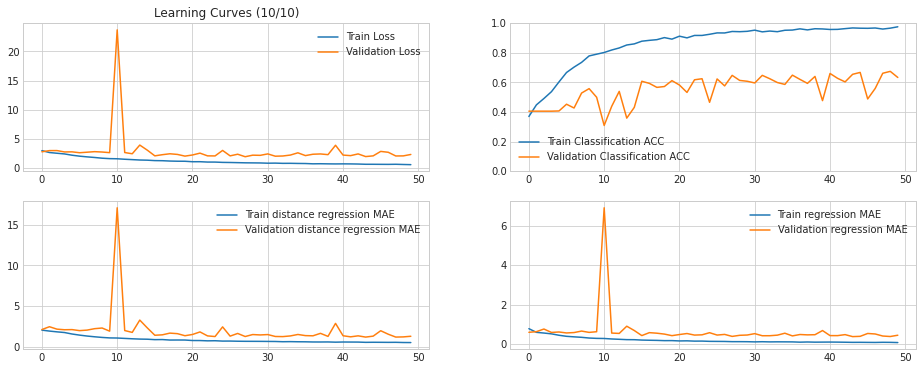

Min. validation loss epoch: 28
Max. Classification ACC epoch: 49
Max. Classification ACC: 0.6747159361839294
Min. distance regression validation MAE epoch: 44
Min. regression validation MAE epoch: 44


In [47]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
total_info_2 =[]

fold_testidx=[]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# model_parm_name="D"+depth+"_"+dropout_rat

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    
    if kfold_idx != 1:
        print(kfold_idx)

        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        print(test_idxs)
        fold_testidx.append(test_idxs)
        # 1. Data
        # ----------------------------------------
        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_test_distance= y_distance[test_idxs]

        label_df_test = label_df.iloc[test_idxs]

        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test,y_test_distance)

        x_test=to224_resize(x_test)

        # 2. Paths
        # ----------------------------------------

    #     output_path_kfold = os.path.join(output_path, model_parm_name, f'kfold_{kfold_idx + 1:02d}/')
        output_path_kfold = os.path.join(output_path,  f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        # 3. Plot Learning Curves.
        # ----------------------------------------

        # log 저장: loss, mae, val_loss, val_mae
        log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))


        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(16, 6))

        plt.subplot(2,2,1)
        plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
        plt.plot(log_df.loss)
        plt.plot(log_df.val_loss)
        plt.legend(('Train Loss', 'Validation Loss'))

        plt.subplot(2,2,2)
        plt.plot(log_df.classification_acc)
        plt.plot(log_df.val_classification_acc)
        plt.ylim(0, 1)
        plt.legend(('Train Classification ACC', 'Validation Classification ACC'))

        plt.subplot(2,2,3)
        plt.plot(log_df.distance_prediction_mae)
        plt.plot(log_df.val_distance_prediction_mae)
        plt.legend(('Train distance regression MAE', 'Validation distance regression MAE'))

        plt.subplot(2,2,4)
        plt.plot(log_df.regression_prediction_mae)
        plt.plot(log_df.val_regression_prediction_mae)
        plt.legend(('Train regression MAE', 'Validation regression MAE'))

        plt.show()
        plt.style.use('seaborn-white')
        print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
        print(f'Max. Classification ACC epoch: {log_df.val_classification_acc.idxmax() + 1}')
        print(f'Max. Classification ACC: {log_df.val_classification_acc[log_df.val_classification_acc.idxmax()]}')
        print(f'Min. distance regression validation MAE epoch: {log_df.val_distance_prediction_mae.idxmin() + 1}')
        print(f'Min. regression validation MAE epoch: {log_df.val_regression_prediction_mae.idxmin() + 1}')



        info_df = label_df.copy()

        result_info_df = info_df.iloc[test_idxs]

        inference_df = result_info_df.copy()
        inference_df2 = result_info_df.copy()

        # 4. Load a Model.
        # ----------------------------------------

    #         K.clear_session()

        #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
        model = models.load_model(os.path.join(output_path, r'model.hdf5'))
        model2 = models.load_model(os.path.join(output_path, r'model.hdf5'))
        #validation mae가 가장 적은 model weight load
        model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_regression_prediction_mae.idxmin() + 1:08d}*.hdf5'))[0])
        model2.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_classification_acc.idxmax() + 1:08d}*.hdf5'))[0])
        # 5. Display
        # ----------------------------------------


        prediction = model.predict(x_test)
        prediction2 = model2.predict(x_test)

        prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
        prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left

        prediction_class_r = prediction2[1][:int(prediction[1].shape[0]/2)] #Right
        prediction_class_l = prediction2[1][int(prediction[1].shape[0]/2):] #left

        r = prediction_distance_r.copy()
        l = prediction_distance_l.copy()

        r2 = prediction_class_r.copy()
        l2 = prediction_class_l.copy()

        #-1~1사이 score
        r = np.round(r) #반올림
        r[r<-1]= -1
        r[r>1] = 1


        l = np.round(l)
        l[l<-1]= -1
        l[l>1] = 1  

        # onehot value score
        r2= r2.tolist()
        r2_2=[]
        for xx in r2:
            if xx[0]==np.max(xx):
                xx=0
            elif xx[1]==np.max(xx):
                xx=1
            elif xx[2]==np.max(xx):
                xx=-1
            r2_2.append(xx)

        l2= l2.tolist()
        l2_2=[]
        for xy in l2:
            if xy[0]==np.max(xy):
                xy=0
            elif xy[1]==np.max(xy):
                xy=1
            elif xy[2]==np.max(xy):
                xy=-1
            l2_2.append(xy)
    #     print(l.shape)
    #     print(r.shape)
    #     print(info_df.shape)
    #     print(result_info_df.shape)

        inference_df['prediction_class_r'] = r
        inference_df['prediction_class_l'] =l
        inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
        inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)

        inference_df2['prediction_class_r']=r2_2
        inference_df2['prediction_class_l']=l2_2
        inference_df2['prediction_onehot_class_r']=r2
        inference_df2['prediction_onehot_class_l']=l2


        inference_df.to_csv(os.path.join(output_path_kfold, r'info_v1_2.csv')) # log_df.val_regression_prediction_mae.idxmin()
        inference_df2.to_csv(os.path.join(output_path_kfold, r'info_v2_2.csv')) # log_df.val_classification_acc.idxmax()

        total_info.append(inference_df)
        total_info_2.append(inference_df2)

    total_df = pd.concat(total_info)
    total_df.to_csv(os.path.join(output_path,'total_v1_2.csv'))

    total_df2 = pd.concat(total_info_2)
    total_df2.to_csv(os.path.join(output_path,'total_v2_2.csv'))

In [31]:
total_df

,Unnamed: 0,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l,prediction_class_r,prediction_class_l,regression_distance_r,regression_distance_l
13,13,QH0083,Post-Tx,-1,-1,-5.30,-5.43,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",1.0,1.0,0.807,0.993
15,15,QH0093,Post-Tx,0,0,0.60,1.62,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",-0.0,1.0,-0.011,1.009
25,25,QH0115,Post-Tx,0,1,0.51,1.87,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-0.0,-0.0,-0.005,-0.008
36,37,QH0158,Post-Tx,0,-1,4.39,2.69,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",-0.0,-0.0,-0.007,-0.007
62,63,QH0349,Post-Tx,-1,-1,-1.21,-1.06,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1.0,-1.0,-1.029,-1.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,2017,QH0523,Post-Tx,0,0,-1.16,-0.68,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",-1.0,-0.0,-0.915,-0.004
1901,2022,QH0541,Pre-Tx,-1,-1,-1.88,-1.79,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1.0,-1.0,-0.915,-0.978
1917,2038,QH0777,Pre-Tx,1,0,4.79,1.53,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",1.0,1.0,0.978,0.976
1941,2064,QH1037,Pre-Tx,0,0,0.95,-0.46,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",-0.0,-0.0,-0.005,-0.006


In [32]:
total_df2

,Unnamed: 0,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l,prediction_class_r,prediction_class_l,prediction_onehot_class_r,prediction_onehot_class_l
13,13,QH0083,Post-Tx,-1,-1,-5.30,-5.43,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",1,1,"[0.24229367077350616, 0.7563996315002441, 0.00...","[0.13263332843780518, 0.8670206069946289, 0.00..."
15,15,QH0093,Post-Tx,0,0,0.60,1.62,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,1,"[0.7983117699623108, 0.09543239325284958, 0.10...","[0.12529754638671875, 0.8743959069252014, 0.00..."
25,25,QH0115,Post-Tx,0,1,0.51,1.87,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",0,0,"[0.7984346151351929, 0.0976618155837059, 0.103...","[0.7983893156051636, 0.0966484397649765, 0.104..."
36,37,QH0158,Post-Tx,0,-1,4.39,2.69,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0,0,"[0.7984007000923157, 0.09686926007270813, 0.10...","[0.7983975410461426, 0.09680600464344025, 0.10..."
62,63,QH0349,Post-Tx,-1,-1,-1.21,-1.06,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1,-1,"[0.12215111404657364, 0.00025213934713974595, ...","[0.13408315181732178, 0.00030859396792948246, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,2017,QH0523,Post-Tx,0,0,-1.16,-0.68,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",-1,0,"[0.17827889323234558, 0.0005785340908914804, 0...","[0.7984487414360046, 0.09809722751379013, 0.10..."
1901,2022,QH0541,Pre-Tx,-1,-1,-1.88,-1.79,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1,-1,"[0.17849276959896088, 0.0005800903309136629, 0...","[0.1450219750404358, 0.00036623343476094306, 0..."
1917,2038,QH0777,Pre-Tx,1,0,4.79,1.53,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",1,1,"[0.13961978256702423, 0.8599940538406372, 0.00...","[0.14074736833572388, 0.8588597774505615, 0.00..."
1941,2064,QH1037,Pre-Tx,0,0,0.95,-0.46,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,0,"[0.7984379529953003, 0.09775681048631668, 0.10...","[0.7984224557876587, 0.09734942018985748, 0.10..."


In [33]:
kfold_results_df = pd.DataFrame(metrics, columns=('test_loss', 'test_mae'))


In [48]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 510  437   56]
 [ 174 1156  163]
 [  47  371  598]]

Accuracy: 0.645


In [50]:
data = total_df2['angle_class_r'].append(total_df2['angle_class_l'])
prediction =  total_df2['prediction_class_r'].append(total_df2['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 564  377   62]
 [ 179 1137  177]
 [  48  353  615]]

Accuracy: 0.659


In [38]:
np.sum(cm)

782

# inference

In [34]:
output_path_root = f'../../results/{MODEL_TYPE}_multiout/5fold/v1_{loss_param}_{MODEL_TYPE}_rg_multiO3_so_img'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

In [35]:
def data_preprocess(x,label):
    label_df = convert_label_class2reg(label)
    
    y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
    y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()
    y = y.astype(np.float32)
    y_distance = y_distance.astype(np.float32)
    
    x = data.astype(np.float32)
    x=preprocess_input(x)    
    
    return x, y, y_distance

def one_hot_df(y_test_onehot):

    y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
    y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]
    
    y_onehot_tt_r=list(y_onehot_tt_r)
    y_onehot_tt_l=list(y_onehot_tt_l)
    
    label_df["one-hot-r"]=y_onehot_tt_r
    label_df["one-hot-l"]=y_onehot_tt_l
    
    return label_df

def regression_predict(prediction):
    prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
    prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left
    
    r = prediction_distance_r.copy()
    l = prediction_distance_l.copy()

    #-1~1사이 score
    r = np.round(r) #반올림
    r[r<-1]= -1
    r[r>1] = 1

    l = np.round(l)
    l[l<-1]= -1
    l[l>1] = 1      

    return prediction_distance_r, prediction_distance_l, int(r),int(l)
    
    
def one_hot_predict(prediction):
    prediction_class_r = prediction2[1][:int(prediction[1].shape[0]/2)] #Right
    prediction_class_l = prediction2[1][int(prediction[1].shape[0]/2):] #left

    r = prediction_class_r.copy()
    l = prediction_class_l.copy()    

    # onehot value score
    r = np.round(r) #반올림
    r= r.tolist()
    r2=[]
    for xx in r:
        if xx==[0.0,0.0,1.0]:
            xx=-1
        elif xx==[1.0,0.0,0.0]:
            xx=0
        else:
            xx=1
        r2.append(xx)

    l = np.round(l)
    l= l.tolist()
    l2=[]
    for xy in l:
        if xy==[0.0,0.0,1.0]:
            xy=-1
        elif xy==[1.0,0.0,0.0]:
            xy=0
        else:
            xy=1
        l2.append(xy)
        
    return r, l, r2, l2
        
    
def inference(data,label_df):
    
    #---------root_path---------
    MODEL_TYPE="nasnet"
    loss_param=0.5
    kfold=1
    output_path_root = f'../../results/{MODEL_TYPE}_multiout/5fold/v1_{loss_param}_{MODEL_TYPE}_rg_multiO3_so_img'
    output_path = os.path.join(output_path_root,  "so_rl", f'kfold_{kfold + 1:02d}/')
    output_path_weight= os.path.join(output_path_kfold, r'weights/')
    #---------------------------
    
    #-----------data------------
    #---------------------------
    x, y, y_distance = data_preprocess(data,label_df)
    x_tt, y_test, y_test_onehot, y_test_distance=generate_data_by_patient(x,y,y_distance)
    
    x_test=to331_resize(x_tt)
    label_df_test=one_hot_df(y_test_onehot)
    #---------------------------
    
    
    inference_df = label_df_test.copy()

    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    model2 = models.load_model(os.path.join(output_path, r'model.hdf5'))
    
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_regression_prediction_mae.idxmin() + 1:08d}*.hdf5'))[0])
    model2.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_classification_acc.idxmax() + 1:08d}*.hdf5'))[0])

    prediction = model.predict(x_test)
    prediction2 = model2.predict(x_test)

    prediction_distance_r, prediction_distance_l, r, l=regression_predict(prediction)
    prediction_class_r, prediction_class_l, r2, l2=regression_predict(prediction2)


    inference_df['regression_prediction_class_r'] = r
    inference_df['regression_prediction_class_l'] = l
    inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
    inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)
    inference_df['onehot_prediction_class_r']=r2
    inference_df['onehot_prediction_class_l']=l2
    inference_df['onehot_class_r']=prediction_class_r
    inference_df['onehot_class_l']=prediction_class_l


    inference_df.to_csv(os.path.join(output_path, r'inference.csv'))
    total_info.append(inference_df)

    total_df = pd.concat(total_info)
    total_df.to_csv(os.path.join(output_path,'total_inference.csv'))
    
    for i in range(x.shape[0]):
        fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(20, 10))
        ax1.set_title(f"S{i:04d}_right_class:{total_df['angle_class_r'][i]}",fontsize=16)
        right = x[i,...,:3]
        ax1.imshow(right,cmap='Greys_r',vmin=right.min(),vmax=right.max())

        ax2.set_title(f"S{i:04d}_left_class:{total_df['angle_class_l'][i]}",fontsize=16)
        left = x[i,...,3:]
        ax2.imshow(left,cmap='Greys_r',vmin=right.min(),vmax=right.max())
    
        print("regression model predict",\n,f"right:{inference_df['regression_prediction_class_r'][i]}||left:{inference_df['regression_prediction_class_l'][i]}")
        print("onehot model predict",\n,f"right:{inference_df['onehot_prediction_class_r'][i]}||left:{inference_df['onehot_prediction_class_l'][i]}")
    
    return inference_df
    

SyntaxError: unexpected character after line continuation character (<ipython-input-35-a91f7da93043>, line 144)